In [1]:
%reload_ext autoreload
%autoreload 2

# Mode solver

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pytrans.analysis import mode_solver

from pytrans.analysis.mode_solver import init_crystal
from pytrans.analysis.mode_solver import HarmonicTrap

from pytrans.ions import Ca40

from scipy.constants import elementary_charge, pi, epsilon_0


## Equilibrium positions in harmonic trap

### From linear to zigzag:

Reference:

James, D. Quantum dynamics of cold trapped ions with application to quantum computation. Appl Phys B 66, 181–190 (1998). https://doi.org/10.1007/s003400050373

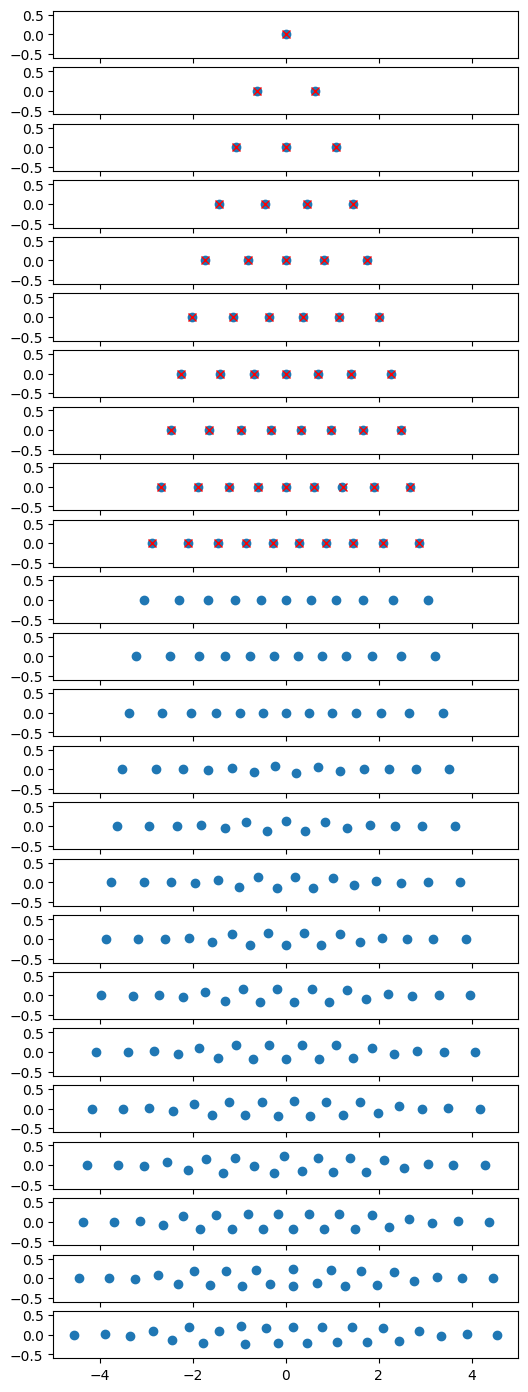

In [3]:

# From [James98], Table 1

scaled_equilibrium_positions = [
    [0.0],
    [-0.63, 0.63],
    [-1.0772, 0.0, 1.0772],
    [-1.4368, -0.4544, 0.4544, 1.4368],
    [-1.7429, -0.8221, -0.0, 0.8221, 1.7429],
    [-2.0123, -1.1361, -0.3699, 0.3699, 1.1361, 2.0123],
    [-2.2545, -1.4129, -0.6869, -0.0, 0.6869, 1.4129, 2.2545],
    [-2.4758, -1.6621, -0.967, -0.318, 0.318, 0.967, 1.6621, 2.4758],
    [-2.6803, -1.8897, -1.2195, -0.5996, -0.0, 0.5996, 1.2195, 1.8897, 2.6803],
    [-2.8708, -2.1001, -1.4503, -0.8538, -0.2823, 0.2823, 0.8538, 1.4503, 2.1001, 2.8708],
]


fx = 1e6
l_scale = (elementary_charge**2 / (4 * pi * epsilon_0) / (Ca40.mass * (2 * pi * fx)**2))**(1 / 3)

harmonic_trap = HarmonicTrap(fx, fy=6e6, fz=10e6, ion=Ca40)


N_max = 25
fig, axes = plt.subplots(N_max - 1, 1, figsize=(6, 0.7 * N_max), sharex=True, squeeze=False)

def solve_for_n_ions(trap, N_ions):
    dx = 2e-6
    x0 = init_crystal((0, 0, 0), dx, N_ions, axis=0, randomize=True)
    result = mode_solver(trap, x0=x0, voltages=None, ions=[Ca40] * N_ions, bounds=None)
    return result, x0

for j, N_ions in enumerate(range(1, N_max)):

    result, x0 = solve_for_n_ions(harmonic_trap, N_ions)
    
    x_eq = result.x_eq
    x_eq1 = x_eq[:, 0] / l_scale

    yy = x_eq[:, 1] / l_scale

    ax = axes[j, 0]
    # ax.plot(x0[:, 0] / l_scale, x0[:, 1] / l_scale, 'o', color='lightgray')
    ax.plot(x_eq1, yy, 'o')
    try:
        ax.plot(scaled_equilibrium_positions[j], np.zeros((N_ions)), 'xr', ms=6)
    except IndexError:
        pass
    ax.set_ylim(-0.6, 0.6)
# ax.invert_yaxis()

# result['res']

## Normal modes of mixed-species ion chain

Reference:

K. Sosnova, A. Carter, and C. Monroe, "Character of motional modes for entanglement and sympathetic cooling of mixed-species trapped-ion chains", Phys. Rev. A 103, 012610 (2021) https://doi.org/10.1103/PhysRevA.103.012610


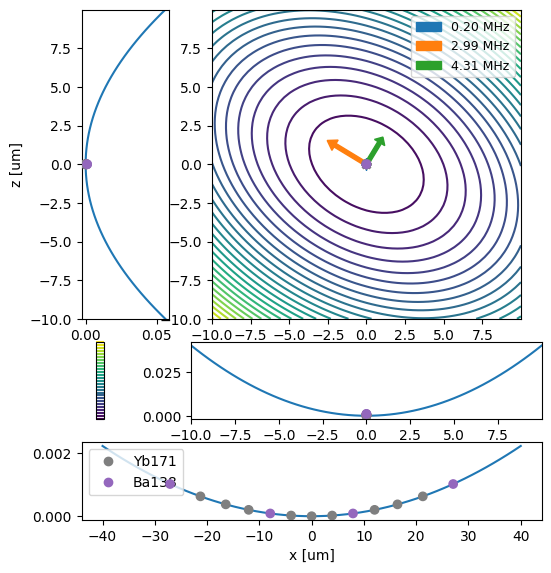

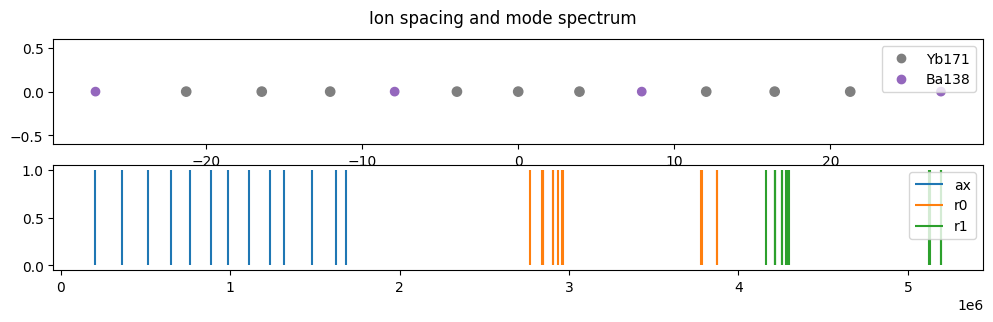

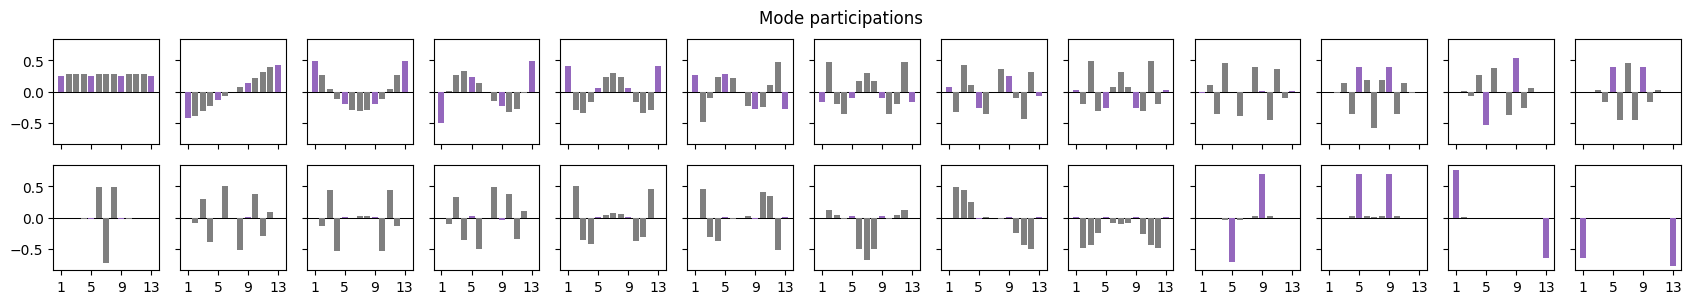

In [38]:
from pytrans.ions import Yb171, Ba138
from pytrans.analysis import analyse_potential

from pytrans.plotting.plotting import _get_ion_color, _add_ions_legend

# wx, wy, wz = 1.3e6, 3.5e6, 4.19e6
wx, wy, wz = 0.2e6, 3.396e6, 4.0e6
trap_freqs = np.asarray([wx, wy, wz])

trap = HarmonicTrap(wx, wy, wz, ion=ion, tilt_yz=3e8)
n_ions = 10
ions = [Ba138, Yb171, Yb171, Yb171] * 3 + [Ba138]

result = analyse_potential(trap, voltages=None, ions=ions, ion1=Yb171, r0=(0, 0, 0), roi=(40e-6, 1e-5, 1e-5), verbose=False)
# result = mode_solver(trap, voltages=None, ions=ions, x0=x0)


trap_freqs = result.mode_freqs
mode_freqs = result.mode_solver_results.mode_freqs
mode_vectors = result.mode_solver_results.mode_vectors
x_eq = result.mode_solver_results.x_eq

# projections of normal modes on single-ion eigenmodes
v1 = result.mode_vectors
proj = abs(np.einsum('Mai,mi', mode_vectors, v1)).sum(1)
mode1_index = np.argmax(proj, axis=1)

mode_vectors_proj = np.asarray([mode_vectors[j] @ v1[mode1_index[j]] for j in range(len(mode_vectors))])

mode_labels = {}
for j, key in enumerate(['ax', 'r0', 'r1']):
    mode_labels[key] = np.where(mode1_index == j)[0]


# --- plot

fig, (ax0, ax) = plt.subplots(2, 1, figsize=(12, 3))
fig.suptitle("Ion spacing and mode spectrum")


ion_colors = [_get_ion_color(ion) for ion in ions]
m_min = min([ion.mass_amu for ion in ions])
s = [(ion.mass_amu / m_min) * plt.rcParams['lines.markersize'] ** 2 for ion in ions]

ax0.scatter(x_eq[:, 0] * 1e6, x_eq[:, 1] * 1e6, c=ion_colors, s=s)
ax0.set_ylim(-0.6, 0.6)
_plot_ions_legend(ax0, ions)

for j, (key, ix) in enumerate(mode_labels.items()):
    f = mode_freqs[ix]
    ax.vlines(f, 0, 1, label=key, color=f"C{j}")
ax.legend()


plot_modes = ['ax', 'r1']
nn = len(ions)

mosaic = [
    [f"{mode}_{j}" for j in range(nn)] for mode in plot_modes
]
fig, axes = plt.subplot_mosaic(mosaic, figsize=(21, 3), sharey=True, sharex=True)
fig.suptitle(f'Mode participations')


for mode in plot_modes:
    mode_vectors_1 = mode_vectors_proj[mode_labels[mode]]
    for j in range(nn):
        m = mode_vectors_1[j]
        ax = axes[f"{mode}_{j}"]
        ax.bar(np.arange(1, len(m) + 1), m, color=ion_colors)
        ax.axhline(0, color='k', lw=0.75, zorder=-1)
        ax.set_xticks([1, 5, 9, 13])
